# Laboratorio 2 - Reglas de Asociación y Patrones Secuenciales

## Grupo 1 - Paula Hípola Gómez, José Ignacio Navas Sanz y Belén Ortega Pérez

## Entregable 1 - Reglas de Asociación

### 1.1 (1 punto) Estudia brevemente el dataset (número de usuarios, número de atributos, categorías más frecuentes para cada atributo/columna, etc.) y realiza el preprocesamiento para generar el dataset necesario para aplicar el algoritmo Apriori a este conjunto de datos.

In [1]:
%config IPCompleter.greedy=True
%reset
#Importamos las librerías necesarias
#Numpy
import numpy as np 
#Pandas
import pandas as pd
#Scikit-Learn
import sklearn as sk
#Matplotlib
import matplotlib.pyplot as plt
#Importamos la libreria mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### Cargamos los datos y los visualizamos

In [2]:
#Importamos el CSV
dataset = pd.read_csv('radio.csv')

#Mostramos los datos
dataset.head()

,user,artist,sex,country
0,1,red hot chili peppers,f,Germany
1,1,the black dahlia murder,f,Germany
2,1,goldfrapp,f,Germany
3,1,dropkick murphys,f,Germany
4,1,le tigre,f,Germany


In [3]:
print('La dimensión del dataset es:',dataset.shape)

La dimensión del dataset es: (289955, 4)


Tenemos 289955 instancias y 4 atributos, para cada una de nuestras instancias. Analizando más profundamente el dataset, está compuesto con las interacciones de cada usuario que ha escuchado al menos a un artista. Vamos a ver cuantos valores tenemos actualmente en cuanto a usuarios, artistas y demás atributos y luego procederemos a identificar en el dataset valores duplicados y nulos que dificultan la comprensión de los datos y procederemos a su eliminación.

### Analizando los datos

In [4]:
#Valores desconocidos
desconocidos = dataset.loc[dataset['artist'] == '[unknown]']
print('Hay ', desconocidos.shape[0], 'valores desconocidos.');

Hay  553 valores desconocidos.


In [5]:
numUsuarios = dataset.groupby('user').count().shape[0]
print('Hay',numUsuarios,'usuarios.')
numArtistas = dataset.groupby('artist').count().shape[0]
print('Hay',numArtistas,'artistas.')
numSexos = dataset.groupby('sex').count().shape[0]
print('Hay',numSexos,'géneros.')
numPaises = dataset.groupby('country').count().shape[0]
print('Hay',numPaises,'países.')

Hay 15000 usuarios.
Hay 1004 artistas.
Hay 2 géneros.
Hay 159 países.


In [6]:
dataset['user'].describe()

count    289955.000000
mean       9852.460447
std        5692.355041
min           1.000000
25%        4935.000000
50%        9838.000000
75%       14769.000000
max       19718.000000
Name: user, dtype: float64

Vemos que el valor máximo para usuarios es 19718 pero realmente hay 15000 usuarios. Esto se debe a que en la tabla tenemos las transacciones de aquellos que han escuchado al menos una canción pero guarda su ID de registro, es decir, cuando un Usuario se registra se le asigna un ID, por ejemplo el 1, pero si ese usuario no escucha ninguna canción, no estará en nuestra base de datos. En cambio si el siguiente usuario con ID 4 si escucha una canción si le tendremos en nuestro registro, de ahí que el valor máximo de usuarios sea 19718 pero realmente solo tenemos 15000.

In [7]:
dataset['artist'].describe()

count        289955
unique         1004
top       radiohead
freq           2704
Name: artist, dtype: object

Respecto a los artistas, antes hemos obtenido que había 1004 y efectivamente es lo que obtenemos cuando llamamos a la funcón 'describe'. Observamos que el artista más escuchado es radiohead, podremos analizar a este artista con respecto a los demás si tenemos algún interés especial en él.

In [8]:
dataset['sex'].describe()

count     289955
unique         2
top            m
freq      211823
Name: sex, dtype: object

Respecto al género, esta columna no nos aporta un valor diferencial. Simplemente nos indica si el usuario es mujer u hombre.

In [9]:
dataset['country'].describe()

count            289955
unique              159
top       United States
freq              59558
Name: country, dtype: object

Respecto al país puede jugar un valor algo más diferencial que el sexo en nuestro dataset pero consideramos que tampoco aporta un valor excesivamente diferencial puesto que nos vamos a centrar en los artistas

### Limpieza de datos

In [10]:
#Valores desconocidos
dataset.loc[dataset['artist'] == '[unknown]']
dataset = dataset.replace('[unknown]',np.NaN)

In [11]:
#Eliminación de nulos
dataset = dataset.dropna()
print('Tamaño sin nulos',dataset.shape)

#Eliminación de duplicados
dataset = dataset.drop_duplicates()
print('Tamaño sin duplicados',dataset.shape)
dataset

Tamaño sin nulos (289402, 4)
Tamaño sin duplicados (289400, 4)


,user,artist,sex,country
0,1,red hot chili peppers,f,Germany
1,1,the black dahlia murder,f,Germany
2,1,goldfrapp,f,Germany
3,1,dropkick murphys,f,Germany
4,1,le tigre,f,Germany
...,...,...,...,...
289950,19718,bob dylan,f,Canada
289951,19718,pixies,f,Canada
289952,19718,the clash,f,Canada
289953,19718,a tribe called quest,f,Canada


Tenemos que hacer un nuevo dataset para analizar estos datos con el algoritmo Apriori, para ello vamos a construir un dataset con un listado de ususarios con todos los artistas que ha escuchado...

In [68]:
dfAgrupado = pd.DataFrame(dataset.groupby(['user','sex','country'],as_index=False)['artist'].agg(lambda x: list(x)))
dfAgrupado

,user,sex,country,artist
0,1,f,Germany,"[red hot chili peppers, the black dahlia murde..."
1,3,m,United States,"[devendra banhart, boards of canada, cocorosie..."
2,4,m,United Kingdom,"[tv on the radio, tool, kyuss, dj shadow, air,..."
3,5,m,Finland,"[dream theater, ac/dc, metallica, iron maiden,..."
4,6,m,Portugal,"[lily allen, kanye west, sigur rós, pink floyd..."
...,...,...,...,...
14990,19713,m,Ukraine,"[armin van buuren, above & beyond, atb, ferry ..."
14991,19714,m,United Kingdom,"[misfits, type o negative, arch enemy, red hot..."
14992,19715,m,United Kingdom,"[abba, james blunt, jason mraz, amy winehouse,..."
14993,19717,m,Brazil,"[marilyn manson, beyoncé, madonna, t.a.t.u., k..."


Como podemos ver, hemos agrupado todos los usuarios, artistas, géneros y países en sus respectivas categorías para comprender mejor el dataset planteado, ahora procederemos a preprocesar y limpiar los datos. Si analizamos este dataset, vemos que tenemos 15000 usuarios si bien este no es un dato real puesto que hay saltos en el ID de usuario. Esto se debe a que tenemos los datos de los usuarios que han escuchado al menos 1 artista por lo que no podemos sacar una conclusión del número exacto de usuarios, si no de que hay 15000 usuarios que han escuchado al menos a un artista.

Pese a tener los datos del país del usuario además de su género, nos damos cuenta de que estos datos carecen de valor y no aportan nada al objetivo que perseguimos, que no es más que la adquisición de los conjuntos de grupos de música más frecuentes para la obtención de reglas de asociación que nos permita el estudio de estos grupos y sus similitudes por el cual se produzcan estos agrupamientos.

## 1.2 (4 puntos) Aprende a manejar la librería mlextend y su implementación del algoritmo Apriori.

In [69]:
te = TransactionEncoder()
te_ary = te.fit(dagrupado).transform(dagrupado)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,...and you will know us by the trail of dead,2pac,3 doors down,30 seconds to mars,311,36 crazyfists,44,50 cent,65daysofstatic,a day to remember,...,wilco,within temptation,wolfgang amadeus mozart,wu-tang clan,yann tiersen,yeah yeah yeahs,yellowcard,yo la tengo,zero 7,Édith piaf
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14990,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14991,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
14992,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
14993,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### 1.2.1 Obtén los itemsets frecuentes para k=1. Para esto es necesario obtener el soporte de los itemset. Crea una función que utilice métodos de la librería mlextend de manera que dado un itemset devuelva su soporte.

In [70]:
#Necesitamos definir un soporte minimo. sabemos que tenemos 14995 instancias, por lo que consideramos que todo lo que este
#por encima de... 250/14995 será para nosotros válido a la hora de operar con ello
frequent_itemsets = apriori(df, min_support=0.010, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets1 = frequent_itemsets[frequent_itemsets['length'] == 1]

In [112]:
frequent_itemsets1.reset_index()

,index,support,itemsets,length
0,0,0.022741,(2pac),1
1,1,0.030944,(3 doors down),1
2,2,0.032811,(30 seconds to mars),1
3,3,0.021807,(50 cent),1
4,4,0.013671,(65daysofstatic),1
...,...,...,...,...
649,649,0.012271,(wilco),1
650,650,0.011937,(within temptation),1
651,651,0.019607,(yann tiersen),1
652,652,0.017339,(yeah yeah yeahs),1


In [72]:
artistas = [];
def soporteItemset(itemset):
    #Obtengo una lista de artistas
    for x in frequent_itemsets1['itemsets']:
        artista = (list(x))
        artistas.append(artista)
    #Recorro la lista de artistas
    for i in range(len(artistas)):
        if itemset in artistas[i]:
            soporte = frequent_itemsets1.loc[i]['support']
            return 'El sporte para ' + str(itemset) + ' es de: ' + str(round(soporte,4))
    return 'El artista ' + str(itemset) + ' no está en el itemset'

In [73]:
coldplay = soporteItemset('coldplay')
print(coldplay)

ecdl = soporteItemset('el canto del loco')
print(ecdl)

beatles = soporteItemset('the beatles')
print(beatles)

El sporte para coldplay es de: 0.1586
El artista el canto del loco no está en el itemset
El sporte para the beatles es de: 0.1779


#### 1.2.2. Crea una función que devuelva los itemsets frecuentes candidatos y su soporte para k>=2



Creamos una función que nos irá calculando itemsets frecuentes candidatos a medida que sea posible para k>=2 y que parará cuando no se generen estos itemsets. Esta función nos sirve además para el siguiente apartado donde se pide más o menos lo mismo

In [74]:
def soporteItemsetKMayorIgual(k):
    #Creamos un diccionario. Esto servira para concatenarlo al nombre del itemset generado
    valoresValidosK = []
    data = dict();
    numCreados = 0;
    if k < 2:
        return 'La k debe ser mayor o igual a 2'
    else:
        while k != -1:
            print('Creando para k = ',k)
            frq = frequent_itemsets[frequent_itemsets['length'] == k]
            if(frq.shape[0] > 0):
                print(frq.shape[0])
                valoresValidosK.append(k);
                var = 'frq'+str(k);
                print(var,'Creado')
                print('Aumentamos k\n')
                k += 1;
                numCreados += 1;
            else:
                print('No se puede generar un itemset para k = ',k)
                print('Paramos el bucle. No generamos nada para k >= ',k)
                k = -1;
        for i in range(numCreados):
            data['frq'+str(valoresValidosK[i])] = frequent_itemsets[frequent_itemsets['length'] == valoresValidosK[i]]        
        print('\nPara obtener los itemsets creados consulte el diccionario que devuelve la funcion.')
        print('Se han generado',numCreados,'datasets')
        return data,numCreados

In [75]:
itemsets, itemSetsGenerados = soporteItemsetKMayorIgual(2)

Creando para k =  2
962
frq2 Creado
Aumentamos k

Creando para k =  3
72
frq3 Creado
Aumentamos k

Creando para k =  4
No se puede generar un itemset para k =  4
Paramos el bucle. No generamos nada para k >=  4

Para obtener los itemsets creados consulte el diccionario que devuelve la funcion.
Se han generado 2 datasets


#### 1.2.3. Crea una función que repita el paso 1.2.2. hasta que no se generen nuevos itemsets frecuentes



La función que hemos generado en el paso 1.2.2 ya nos hace automáticamente esta función. Es decir, hemos creado una función que nos genera automáticamente los itemsets para k>=2 y que para cuando no hay itemsets frecuentes, por tanto no es necesario volver a repetir esta función

In [76]:
k2 = pd.DataFrame.from_dict(itemsets['frq2'])
k2

,support,itemsets,length
654,0.011070,"(3 doors down, linkin park)",2
655,0.012538,"(30 seconds to mars, linkin park)",2
656,0.011337,"(a perfect circle, muse)",2
657,0.010337,"(a perfect circle, nine inch nails)",2
658,0.013471,"(a perfect circle, radiohead)",2
...,...,...,...
1611,0.011204,"(the white stripes, the rolling stones)",2
1612,0.012738,"(the who, the rolling stones)",2
1613,0.012538,"(u2, the rolling stones)",2
1614,0.010137,"(the white stripes, the smashing pumpkins)",2


In [77]:
k3 = pd.DataFrame.from_dict(itemsets['frq3'])
k3

,support,itemsets,length
1616,0.011604,"(coldplay, arctic monkeys, muse)",3
1617,0.013071,"(coldplay, arctic monkeys, radiohead)",3
1618,0.012337,"(arctic monkeys, coldplay, the killers)",3
1619,0.011004,"(arctic monkeys, radiohead, muse)",3
1620,0.011070,"(arctic monkeys, the killers, muse)",3
...,...,...,...
1683,0.010604,"(the beatles, the rolling stones, radiohead)",3
1684,0.010670,"(the beatles, the shins, radiohead)",3
1685,0.011470,"(the beatles, radiohead, the smashing pumpkins)",3
1686,0.010470,"(the beatles, radiohead, the strokes)",3


#### 1.2.4. Crea una función que muestre todas las reglas posibles con su confianza



In [124]:
def sacarReglas(itemsets):
    reglas = association_rules(itemsets, support_only=False, metric="confidence", min_threshold=0.015)
    reglas = reglas[['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'lift', 'confidence']]
    return reglas
sacarReglas(frequent_itemsets)

,antecedents,consequents,antecedent support,consequent support,support,lift,confidence
0,(3 doors down),(linkin park),0.030944,0.098233,0.011070,3.641949,0.357759
1,(linkin park),(3 doors down),0.098233,0.030944,0.011070,3.641949,0.112695
2,(30 seconds to mars),(linkin park),0.032811,0.098233,0.012538,3.889882,0.382114
3,(linkin park),(30 seconds to mars),0.098233,0.032811,0.012538,3.889882,0.127631
4,(a perfect circle),(muse),0.036746,0.114105,0.011337,2.703920,0.308530
...,...,...,...,...,...,...,...
2351,"(the beatles, radiohead)",(the white stripes),0.058219,0.069223,0.012271,3.044757,0.210767
2352,"(the white stripes, radiohead)",(the beatles),0.027276,0.177926,0.012271,2.528455,0.449878
2353,(the beatles),"(the white stripes, radiohead)",0.177926,0.027276,0.012271,2.528455,0.068966
2354,(the white stripes),"(the beatles, radiohead)",0.069223,0.058219,0.012271,3.044757,0.177264


#### 1.2.5. Lista todas las reglas que sean de alta confianza (p.ej. con valor >=0.5)



In [79]:
reglasAltaConfi = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)
reglasAltaConfi = reglasAltaConfi[['antecedents', 'consequents', 'confidence', 'lift']]

In [80]:
reglasAltaConfi

,antecedents,consequents,confidence,lift
0,(beck),(radiohead),0.509281,2.824210
1,(blur),(radiohead),0.522863,2.899530
2,(broken social scene),(radiohead),0.547215,3.034577
3,(keane),(coldplay),0.637405,4.019294
4,(snow patrol),(coldplay),0.525132,3.311337
5,(the fray),(coldplay),0.516820,3.258919
6,(travis),(coldplay),0.562842,3.549121
7,(judas priest),(iron maiden),0.507500,8.560138
8,(t.i.),(kanye west),0.567273,8.851462
9,(megadeth),(metallica),0.528139,4.742178


#### 1.2.6. Crea funciones que permitan lo siguiente:
<ul>
    <li><b>* devolver todas las reglas que contengan un antecesor dado</b></li>
    <li><b>* devolver todas las reglas que tengan una confianza mayor (o igual) que un umbral mínimo dado</b></li>
    <li><b>* devolver todas las reglas que tengan un lift en una de las tres franjas de estudio (under 1, over 1, =1)</b></li>
</ul>



In [81]:
def reglasAntecesor(antecesor):
    antecedents = reglasAltaConfi['antecedents']
    index = antecedents.where([bool(antecesor in a) for a in list(antecedents)]).dropna().index
    return reglasAltaConfi.loc[index, :]

#### Reglas con un antecesor dado por parámetro

In [82]:
reglasAntecesor('the killers')

,antecedents,consequents,confidence,lift
16,"(the killers, bloc party)",(coldplay),0.523659,3.302048
20,"(the killers, death cab for cutie)",(coldplay),0.588448,3.710586
21,"(the killers, muse)",(coldplay),0.508969,3.209413
24,"(oasis, the killers)",(coldplay),0.662698,4.178790
27,"(the killers, radiohead)",(coldplay),0.524362,3.306479
30,"(red hot chili peppers, the killers)",(coldplay),0.509375,3.211976
31,"(snow patrol, the killers)",(coldplay),0.595420,3.754550
32,"(the beatles, the killers)",(coldplay),0.534091,3.367827


In [83]:
def reglasConfianza(confianza):
    confidence = reglasAltaConfi['confidence']
    index = confidence.where(confidence >= confianza).dropna().index
    return reglasAltaConfi.loc[index, :] 

#### Reglas con la confianza mayor o igual que un valor dado

In [84]:
reglasConfianza(0.6)

,antecedents,consequents,confidence,lift
3,(keane),(coldplay),0.637405,4.019294
17,"(pink floyd, bob dylan)",(the beatles),0.615079,3.456940
24,"(oasis, the killers)",(coldplay),0.662698,4.178790
26,"(snow patrol, radiohead)",(coldplay),0.634454,4.000687
28,"(coldplay, the smashing pumpkins)",(radiohead),0.628352,3.484521
45,"(the beatles, sigur rós)",(radiohead),0.643443,3.568203
48,"(the beatles, the smashing pumpkins)",(radiohead),0.620939,3.443408


In [85]:
def reglasLift(lft):
    lift = reglasAltaConfi['lift']
    if lft == 1: 
        index = lift.where(lift == lft).dropna().index
    elif lft > 1:
        index = lift.where(lift > lft).dropna().index
    elif lft < 1:
        index = lift.where(lift < lft).dropna().index
    
    return reglasAltaConfi.loc[index, :]

#### Reglas con Lift dado

In [86]:
reglasLift(0.9)

,antecedents,consequents,confidence,lift


In [87]:
reglasLift(1)

,antecedents,consequents,confidence,lift


In [88]:
reglasLift(1.1)

,antecedents,consequents,confidence,lift
0,(beck),(radiohead),0.509281,2.824210
1,(blur),(radiohead),0.522863,2.899530
2,(broken social scene),(radiohead),0.547215,3.034577
3,(keane),(coldplay),0.637405,4.019294
4,(snow patrol),(coldplay),0.525132,3.311337
5,(the fray),(coldplay),0.516820,3.258919
6,(travis),(coldplay),0.562842,3.549121
7,(judas priest),(iron maiden),0.507500,8.560138
8,(t.i.),(kanye west),0.567273,8.851462
9,(megadeth),(metallica),0.528139,4.742178


#### 1.2.7. Utiliza al menos dos representaciones gráficas para mostrar las reglas obtenidas e interpretar los datos

No sabemos a qué reglas se refiere el enunciado por lo que hemos decidido que vamos a representar las reglas que tienen una serie de antecesores dados, por ejemplo, vamos a coger dos grupos similares como The Killers y Coldplay y ver como se comportan los usuarios a la hora de escucharlos.

Por otro lado vamos a analizar las reglas con alta confidencia para ver la influencia de estas y si tiene relación con las demás.

In [109]:
items = itemsets['frq2']['itemsets']
items

654                    (3 doors down, linkin park)
655              (30 seconds to mars, linkin park)
656                       (a perfect circle, muse)
657            (a perfect circle, nine inch nails)
658                  (a perfect circle, radiohead)
                           ...                    
1611       (the white stripes, the rolling stones)
1612                 (the who, the rolling stones)
1613                      (u2, the rolling stones)
1614    (the white stripes, the smashing pumpkins)
1615              (the white stripes, the strokes)
Name: itemsets, Length: 962, dtype: object

In [146]:
reglasGenerales = sacarReglas(frequent_itemsets)
reglasGenerales["antecedents"] = reglasGenerales["antecedents"].apply(lambda x: list(x)[0]).astype("unicode")
reglasGenerales["consequents"] = reglasGenerales["consequents"].apply(lambda x: list(x)[0]).astype("unicode")
reglasGenerales

,antecedents,consequents,antecedent support,consequent support,support,lift,confidence
0,3 doors down,linkin park,0.030944,0.098233,0.011070,3.641949,0.357759
1,linkin park,3 doors down,0.098233,0.030944,0.011070,3.641949,0.112695
2,30 seconds to mars,linkin park,0.032811,0.098233,0.012538,3.889882,0.382114
3,linkin park,30 seconds to mars,0.098233,0.032811,0.012538,3.889882,0.127631
4,a perfect circle,muse,0.036746,0.114105,0.011337,2.703920,0.308530
...,...,...,...,...,...,...,...
2351,the beatles,the white stripes,0.058219,0.069223,0.012271,3.044757,0.210767
2352,the white stripes,the beatles,0.027276,0.177926,0.012271,2.528455,0.449878
2353,the beatles,the white stripes,0.177926,0.027276,0.012271,2.528455,0.068966
2354,the white stripes,the beatles,0.069223,0.058219,0.012271,3.044757,0.177264


In [147]:
soporte = reglasGenerales['support'].values
confianza = reglasGenerales['confidence'].values

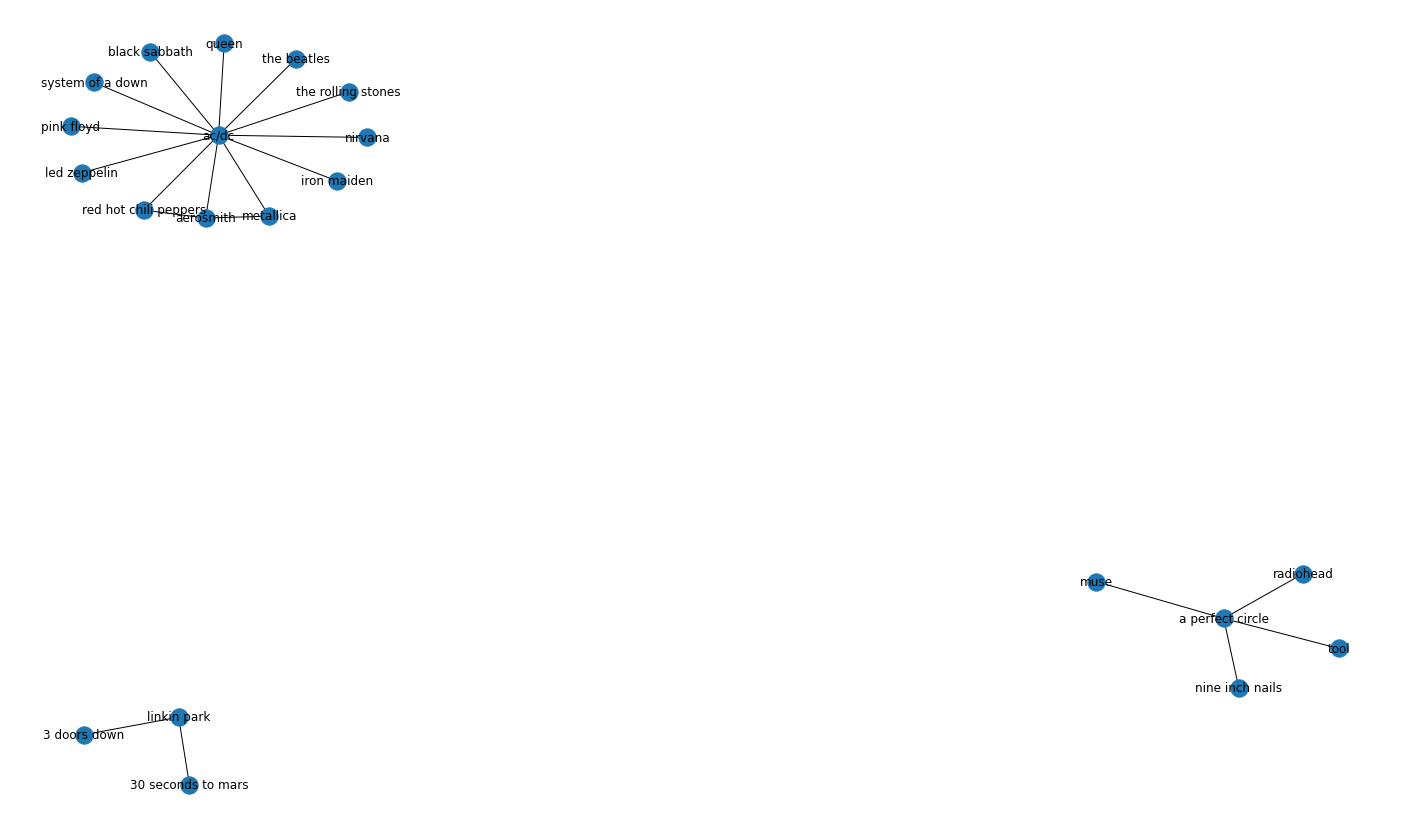

In [155]:
import networkx as nx
fig, ax=plt.subplots(figsize=(25,15))
GA=nx.from_pandas_edgelist(reglasGenerales[1:40],source='antecedents',target='consequents')
nx.draw(GA,with_labels=True)
plt.show()

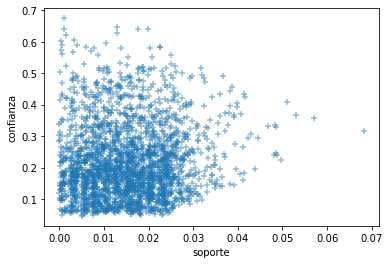

In [92]:
import random
import matplotlib.pyplot as plt
 
for i in range (len(soporte)):
    soporte[i] = soporte[i] + 0.0025 * (random.randint(1,10) - 5) 
    confianza[i] = confianza[i] + 0.0025 * (random.randint(1,10) - 5)
    
plt.scatter(soporte, confianza, alpha=0.5, marker="+")
plt.xlabel('soporte')
plt.ylabel('confianza') 
plt.show()